# Length of Stay (LOS) Classification Using Predictive Modelling 

Used predictive models to classify if a patient will have an ICU visit that’s over 4 days



In [665]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import pprint
from itertools import cycle, islice

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

#hide warnings
import warnings
warnings.filterwarnings('ignore')

Aqcuiring Dataset.

In [666]:
data = pd.read_csv('dataSetExport_sapsi_sofa_min_max_service.csv')

#Remove the visit id - not relevant to our problem.
#Hold 2 datasets:
    # 1. data_full - includes label column. Used for analysis and presentation
    # 2. X - no label column. Used for model training
data_full = data.drop('hadm_id', 1)
data_full.head()

,age,sex,ethnicity_descr,admission_type_descr,admission_source_descr,overall_payor_group_descr,height,weight_first,sapsi_min,sapsi_max,sofa_min,sofa_max,description,icustay_first_service,icustay_first_careunit,LOS
0,71,M,UNKNOWN/NOT SPECIFIED,URGENT,TRANSFER FROM HOSP/EXTRAM,MEDICARE-PRIVATE,185.42,96.6,19.0,19.0,8.0,8.0,CORONARY BYPASS W/O CARDIAC CATH,CSRU,CSRU,12
1,79,F,UNKNOWN/NOT SPECIFIED,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,MEDICARE,162.56,104.5,19.0,19.0,1.0,11.0,CORONARY BYPASS W/O CARDIAC CATH,CCU,CCU,11
2,64,F,WHITE,ELECTIVE,PHYS REFERRAL/NORMAL DELI,PRIVATE,167.64,112.0,16.0,16.0,7.0,7.0,CORONARY BYPASS W/O CARDIAC CATH,CSRU,CSRU,10
3,85,M,UNKNOWN/NOT SPECIFIED,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,MEDICARE,175.26,65.2,7.0,22.0,0.0,6.0,CORONARY BYPASS W/O CARDIAC CATH,CSRU,CSRU,11
4,67,M,WHITE,ELECTIVE,PHYS REFERRAL/NORMAL DELI,MEDICARE,167.64,84.0,10.0,21.0,4.0,15.0,CORONARY BYPASS W/O CARDIAC CATH,CSRU,CSRU,18


Seperate the label column: LOS

In [667]:
y = data_full['LOS']
X = data_full.drop('LOS', 1)

## Analyzing the Data

Breaking down the dataset to understand its characteristics
- Categorical: ethnicity_descr, sex, admission_type_descr, admission_source_descr, overall_payor_group_descr, description  
- Continuous: age, height, weight_first	sapsi_first	sofa_first 
- Mixed: None
- Errors or Typos: description
- Null or empty values: height, weight_first, sapsi_first, sofa_first	

Data types 

- total: 5367  records
- height has missing values
- weight has missing values
- sapsi has missing values

In [668]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 16 columns):
age                          5367 non-null int64
sex                          5356 non-null object
ethnicity_descr              5367 non-null object
admission_type_descr         5367 non-null object
admission_source_descr       5367 non-null object
overall_payor_group_descr    5367 non-null object
height                       2115 non-null float64
weight_first                 4491 non-null float64
sapsi_min                    4579 non-null float64
sapsi_max                    4579 non-null float64
sofa_min                     5165 non-null float64
sofa_max                     5165 non-null float64
description                  5367 non-null object
icustay_first_service        5367 non-null object
icustay_first_careunit       5367 non-null object
LOS                          5367 non-null int64
dtypes: float64(6), int64(2), object(8)
memory usage: 671.0+ KB


### Describing the Data 

Numerical types 
- Age
    - 75% of the patients are older than 60 years
    - 25% of the patients are older than 82 years

- LOS 
    - 75% of the visits are longer than 5 days
    - 25% of the visits are longer than 17 days

In [669]:
data_full.describe()

,age,height,weight_first,sapsi_min,sapsi_max,sofa_min,sofa_max,LOS
count,5367.000000,2115.000000,4491.00000,4579.000000,4579.000000,5165.000000,5165.000000,5367.000000
mean,69.763182,167.131551,77.11077,11.791002,16.644027,3.472798,7.612585,13.772871
std,15.911351,21.714571,24.13166,4.871323,5.737139,3.262093,4.621620,16.515583
min,0.000000,12.700000,0.38000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,60.000000,160.020000,61.90000,9.000000,12.000000,1.000000,4.000000,5.000000
50%,73.000000,167.640000,73.60000,11.000000,16.000000,3.000000,7.000000,9.000000
75%,82.000000,177.800000,88.40000,14.000000,20.000000,5.000000,10.000000,17.000000
max,105.000000,457.200000,285.50000,38.000000,42.000000,22.000000,24.000000,295.000000


Addition of another column called long_stay for classification purposes. 

## Long stay is a an icu visit that is over 4 days

In [670]:
y = (y > 4).astype(int)

# add long_stay to data_full
# column name will be LOS_long_stay
data_full = data_full.join(y, rsuffix='_long_stay')

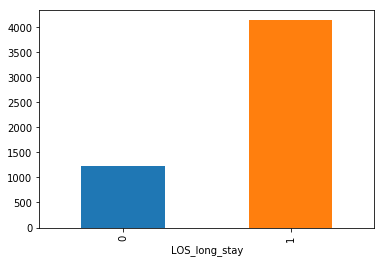

In [672]:
data_full.groupby('LOS_long_stay').size().plot.bar()

### Categorical Types 

- Sex
    - 53% males
- Ethnicity
    - 17 unique ethnicities 
    - 70% white
- Admission Types
    - 4 unique
    - 87% emergency

In [673]:
data_full.describe(include=['O'])

,sex,ethnicity_descr,admission_type_descr,admission_source_descr,overall_payor_group_descr,description,icustay_first_service,icustay_first_careunit
count,5356,5367,5367,5367,5367,5367,5367,5367
unique,2,17,4,8,8,331,6,6
top,M,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,MEDICARE,RESPIRATORY SYSTEM DIAGNOSIS WITH VENTIL,MICU,MICU
freq,2879,3773,4679,3352,3312,336,2630,2126


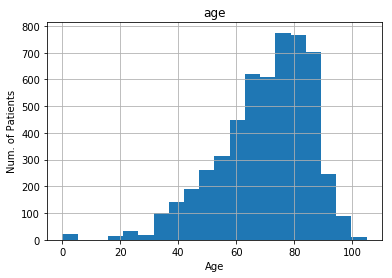

In [678]:
age_histogram = data_full.hist(column='age', bins=20)
for ax in age_histogram.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("Num. of Patients")

## Insurance Types

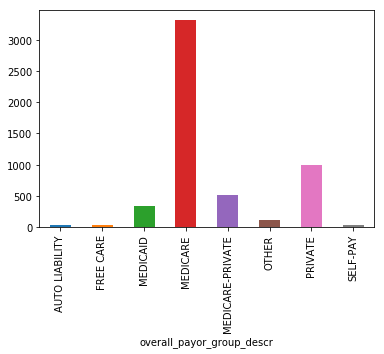

In [679]:
data_full.groupby('overall_payor_group_descr').size().plot.bar()

## Admission Types

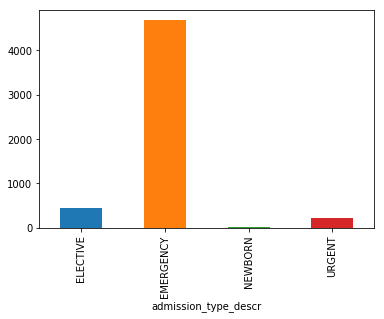

In [680]:
data_full.groupby('admission_type_descr').size().plot.bar()

## First Care Unit

- CCU - Coronary (or cardiac) Intensive Care Unit that takes patients who have cardiac-related problems 
- CSRU -  critical care unit that specializes in the care of the post-operative cardiac surgery patient
- FICU - fetal intensive care unit
- MICU - acute care for adult and geriatric critically ill medical patients
- NICU - Neonatal Intensive Care Unit
- SICU - Surgical Intensive Care Unit

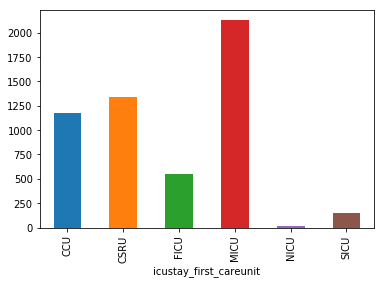

In [681]:
data_full.groupby('icustay_first_careunit').size().plot.bar()

# Completing Missing Values

A simple way is to generate random numbers between mean and standard deviation.

Missing numerical/boolean values in columns: 
    - sex (11 missing values)
    - weight (878 missing values)
    - SAPSI Score (790 missing values)
    - SOFA Score (202 missing values)
<hr>

Examples of null records for each category:


In [682]:
#Changes here are for training phase pre-processing, work on X dataset

columns = [ 'weight_first', 'height', 
           'sapsi_first', 'sofa_first',
           'sapsi_min', 'sapsi_max', 'sofa_min', 'sofa_max'
          ]

for col in columns:
    std = X[col].std()
    mean = X[col].mean()
    low = int (mean - std)
    high = int (mean + std)
    
    X[col] = X[col].apply(lambda x: np.random.choice([x for x in range(low, high)]) if (np.isnan(x)) else x)

X['sex'] = X['sex'].apply(lambda x: np.random.choice(['M', 'F']) if (pd.isnull(x)) else x)

Check that all columns are complete

In [683]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5367 entries, 0 to 5366
Data columns (total 15 columns):
age                          5367 non-null int64
sex                          5367 non-null object
ethnicity_descr              5367 non-null object
admission_type_descr         5367 non-null object
admission_source_descr       5367 non-null object
overall_payor_group_descr    5367 non-null object
height                       5367 non-null float64
weight_first                 5367 non-null float64
sapsi_min                    5367 non-null float64
sapsi_max                    5367 non-null float64
sofa_min                     5367 non-null float64
sofa_max                     5367 non-null float64
description                  5367 non-null object
icustay_first_service        5367 non-null object
icustay_first_careunit       5367 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 629.0+ KB


In [684]:
#add BMI 
X['BMI'] = X['weight_first'] / np.square((X['height'] / 100))

#deal with a 6 bad outliers
X.loc[X['BMI'] >= 100, 'BMI'] = 30

#add to train set as well
data_full['BMI'] = X['BMI']

## Finding Correlations

See how different attributes in our data set correlate to the LOS


In [685]:
data_full['AgeBand'] = pd.cut(data_full['age'], 8)
data_full[['AgeBand', 'LOS_long_stay']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,LOS_long_stay
0,"(-0.105, 13.125]",0.450000
1,"(13.125, 26.25]",0.604167
2,"(26.25, 39.375]",0.643564
3,"(39.375, 52.5]",0.773438
4,"(52.5, 65.625]",0.799629
5,"(65.625, 78.75]",0.786517
6,"(78.75, 91.875]",0.756467
7,"(91.875, 105.0]",0.761905


## Scatter Matrix

A scatter matrix shows how each pair of attributes is correlated. The diagonal of the matrix is the column's histogram.

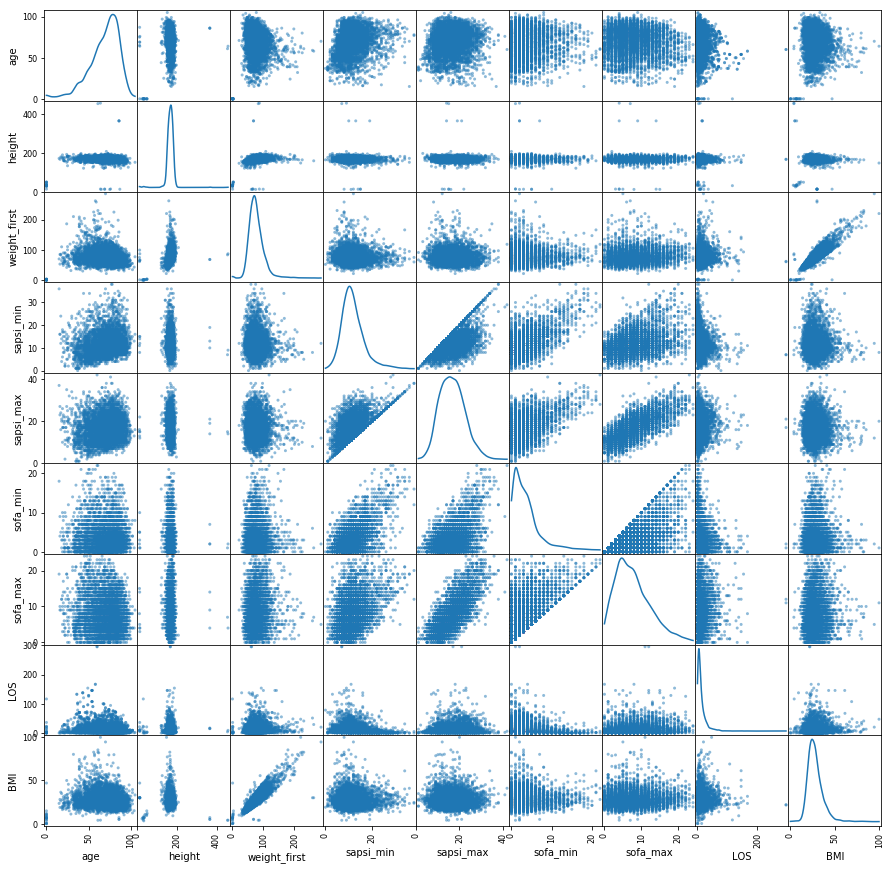

In [686]:
from pandas.plotting import scatter_matrix

scatter_matrix(data_full.loc[:, data_full.columns != 'LOS_long_stay'] ,  figsize  = [15, 15], diagonal = "kde")
plt.show()

## Map Text to Numerical Data

Use one-hot-encoding to convert categorical features to numerical.

In [687]:
# Here we are making changes on the dataset that will be used for training - X

categorical_columns = ['description', 
                       'admission_source_descr', 'overall_payor_group_descr', 
                       'sex', 'ethnicity_descr', 
                       'admission_type_descr',
                      'icustay_first_service',
                      'icustay_first_careunit']

for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in X.columns:
        one_hot_encoded = pd.get_dummies(X[col])
        X = X.drop(col, axis=1)
        X = X.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')

Examine data set after running the one-hot encoder

Since age_band is a range, we need to map each age_band to a numerical value. No need for one-hot since age groups can be represented by proximity of integers

In [688]:
X.loc[ X['age'] <= 13.0, 'age'] = 0
X.loc[(X['age'] > 13.0) & (X['age'] <= 26.0), 'age'] = 1
X.loc[(X['age'] > 26.0) & (X['age'] <= 39.0), 'age'] = 2
X.loc[(X['age'] > 39.0) & (X['age'] <= 52.0), 'age'] = 3
X.loc[(X['age'] > 52.0) & (X['age'] <= 65.0), 'age'] = 4
X.loc[(X['age'] > 65.0) & (X['age'] <= 78.0), 'age'] = 5
X.loc[(X['age'] > 78.0) & (X['age'] <= 91.0), 'age'] = 6
X.loc[ X['age'] > 91, 'age'] = 7

X.head()


,age,height,weight_first,sapsi_min,sapsi_max,sofa_min,sofa_max,BMI,CORONARY BYPASS W/O CARDIAC CATH,CORONARY BYPASS W/O PTCA OR CARDIAC CAT,...,FICU_left,MICU_left,NICU_left,SICU_left,CCU_right,CSRU_right,FICU_right,MICU_right,NICU_right,SICU_right
0,5,185.42,96.6,19.0,19.0,8.0,8.0,28.097260,1,0,...,0,0,0,0,0,1,0,0,0,0
1,6,162.56,104.5,19.0,19.0,1.0,11.0,39.544757,1,0,...,0,0,0,0,1,0,0,0,0,0
2,4,167.64,112.0,16.0,16.0,7.0,7.0,39.853156,1,0,...,0,0,0,0,0,1,0,0,0,0
3,6,175.26,65.2,7.0,22.0,0.0,6.0,21.226676,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,167.64,84.0,10.0,21.0,4.0,15.0,29.889867,1,0,...,0,0,0,0,0,1,0,0,0,0


## Train-test split

test size = 30%

In [689]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [690]:
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (3756, 390)
X_test:  (1611, 390)
y_train:  (3756,)
y_test:  (1611,)


# Training Phase

In [691]:
# Load libraries
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [692]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy' 

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(C=1, max_iter=100, penalty='l2', solver='newton-cg')))
models.append(('LR2', LogisticRegression(C=2, max_iter=100, penalty='l1', solver='liblinear', tol=0.001)))
models.append(('RF', RandomForestClassifier(bootstrap=False, max_features='auto', min_samples_split=40, n_estimators=70)))
models.append(('SGD', SGDClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 
 


LR: 0.781957 (0.023389)
LR2: 0.783818 (0.020930)
RF: 0.789405 (0.020912)
SGD: 0.622667 (0.164485)
LDA: 0.772630 (0.022659)
KNN: 0.750272 (0.023790)
CART: 0.719121 (0.034609)
NB: 0.386597 (0.017915)


## Refining best models parameters

Here we choose the 3 models that did best:

RandomForestClassifier, LinearDiscriminantAnalysis, LogisticRegression.

We'll run a grid-search on each one of them to refine the results.




In [173]:
from sklearn.model_selection import GridSearchCV

# LogisticRegression parameters
param_grid = [
        {'penalty': ['l2'], 'C': [4, 2, 1, 0.8, 0.1],
         'tol': [0.0001, 0.001, 0.01, 0.1],
         'solver' : ['newton-cg', 'lbfgs', 'sag'],
         'max_iter' : [100, 200],
         'warm_start' : [True, False]
         
        },
        {'penalty': ['l1', 'l2'], 'C': [4, 2, 1, 0.8, 0.1],
         'tol': [0.0001, 0.001, 0.01, 0.1],
         'solver' : [ 'liblinear', 'saga'],
         'max_iter' : [100, 200]
        },
]

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=10)
grid_search.fit(X_train, y_train)

print ('\nLogisticRegression grid search best params: ')
print (grid_search.best_params_)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   23.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   29.7s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   31.3s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   32.9s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   34.4s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   39.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   40.6s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   48.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 222 tasks      | elapsed:  1.5min
[Paralle


LogisticRegression grid search best params: 
{'C': 2, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  8.8min finished


In [175]:
from sklearn.model_selection import GridSearchCV

# RandomForestClassifier parameters
param_grid = [
        {'n_estimators': [10, 20, 30, 50, 70], 
         'max_features': ['auto', 100, 200, 300],
         'min_samples_split': [2, 6, 8, 12, 16, 30, 40, 60]
        }
]

rd_cls = RandomForestClassifier()
grid_search = GridSearchCV(rd_cls, param_grid, cv=10, scoring='accuracy', verbose=10, n_jobs=10)
grid_search.fit(X_train, y_train)

print ('\nLogisticRegression grid search best params: ')
print (grid_search.best_params_)


"\n# RandomForestClassifier parameters\nparam_grid = [\n        {'n_estimators': [10, 20, 30, 50, 70], \n         'max_features': ['auto', 100, 200, 300],\n         'min_samples_split': [2, 6, 8, 12, 16, 30, 40, 60]\n        }\n]\n\nrd_cls = RandomForestClassifier()\ngrid_search = GridSearchCV(rd_cls, param_grid, cv=10, scoring='accuracy', verbose=10, n_jobs=10)\ngrid_search.fit(X_train, y_train)\n\nprint ('\nLogisticRegression grid search best params: ')\nprint (grid_search.best_params_)\n"

In [642]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


rf = RandomForestClassifier(bootstrap=False, max_features='auto', min_samples_split=40, n_estimators=70)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)

#y_test_pred = cross_val_predict(rf, X_test, y_test, cv=3)
conf_mx = confusion_matrix(y_test, y_test_pred)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  60
FP:  308
FN:  15
TP:  1228
0.9879324215607401 0.7994791666666666


Print precision, recall and accuracy

In [643]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print (precision_score(y_test, y_test_pred))
print (recall_score(y_test, y_test_pred) )
print (accuracy_score(y_test, y_test_pred))

0.7994791666666666
0.9879324215607401
0.7995034140285537


## At this point we pickle the model instance and deploy it as a RESTful API